# Testing software

In [2]:
import numpy as np
from matplotlib import pyplot as plt
import h5py
import os
import stan_utility
import corner
import astropy.units as u
%load_ext autoreload
%autoreload 2
import seaborn as sns

## Sources

In [3]:
from python.source.parameter import Parameter
from python.source.source import Sources, PointSource

In [4]:
# define high-level parameters
Parameter.clear_registry()
index = Parameter(2.4, "index", fixed=False, par_range=(1.0, 4))
L = Parameter(1E47 * (u.erg / u.s), "luminosity", fixed=True, par_range=(0, 1E60))
diffuse_norm = Parameter(1.44E-14 /u.GeV/u.m**2/u.s, "diffuse_norm", fixed=True, 
                         par_range=(0, np.inf))
Enorm = Parameter(1E5 * u.GeV, "Enorm", fixed=True)
Emin = Parameter(1E5 * u.GeV, "Emin", fixed=True)
Emax = Parameter(1E8 * u.GeV, "Emax", fixed=True)
Emin_det = Parameter(1E5 * u.GeV, "Emin_det", fixed=True)

# Single PS for testing and usual components
point_source = PointSource.make_powerlaw_source("test", np.deg2rad(5)*u.rad,
                                                np.pi*u.rad, 
                                                L, index, 0.42344, Emin, Emax)
my_sources = Sources()
my_sources.add(point_source)
my_sources.add_diffuse_component(diffuse_norm, Enorm.value) # auto diffuse component 
my_sources.add_atmospheric_component() # auto atmo component

In [37]:
my_sources.associated_fraction()

<Quantity 0.13348575>

## Simulation

In [38]:
from python.simulation import Simulation
from python.detector_model import NorthernTracksDetectorModel

In [39]:
obs_time = 10 * u.year
sim = Simulation(my_sources, NorthernTracksDetectorModel, obs_time)
sim.setup_and_run()
sim.save("output/test_sim_file.h5")

Using cached StanModel
Using cached StanModel


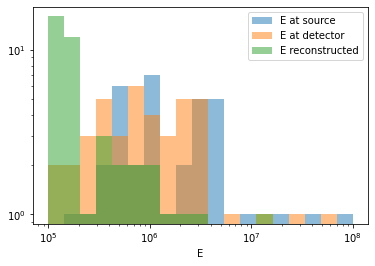

In [40]:
fig, ax = sim.show_spectrum()

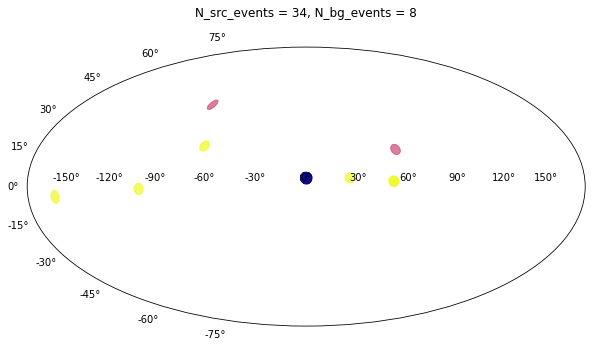

In [41]:
fig, ax = sim.show_skymap()

## Fit 

In [10]:
from python.events import Events
from python.fit import StanFit
from python.detector_model import NorthernTracksDetectorModel

In [11]:
events = Events.from_file("output/test_sim_file.h5")
obs_time = 10 * u.year

In [12]:
fit = StanFit(my_sources, NorthernTracksDetectorModel, events, obs_time)
fit.setup_and_run()

Using cached StanModel


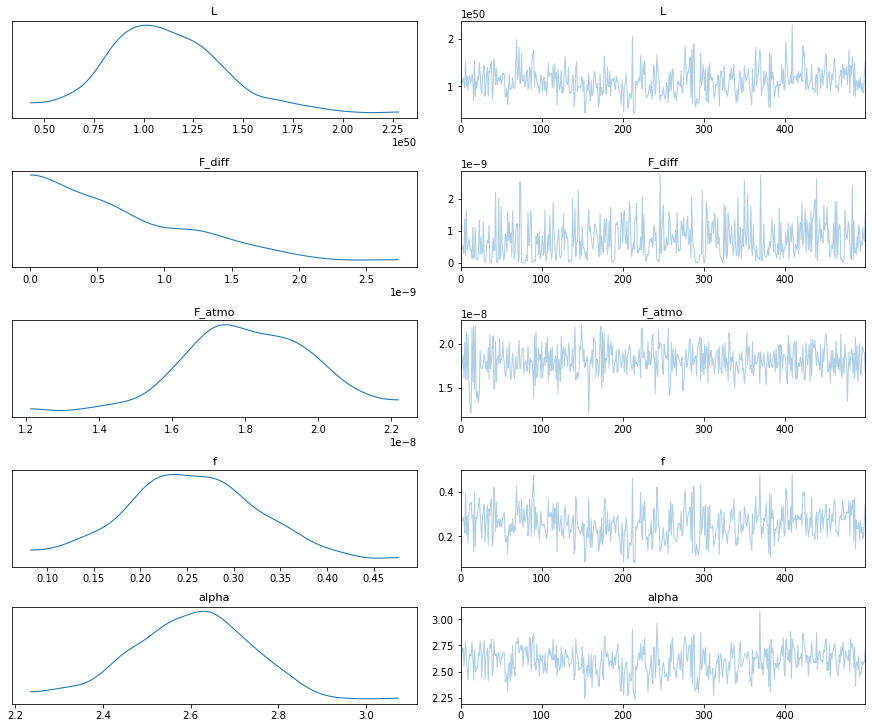

In [25]:
fit.plot_trace(var_names=["L", "F_diff", "F_atmo", "f", "alpha"])

In [33]:
sim_inputs = {}
with h5py.File("output/test_sim_file.h5", "r") as f:
    for key in f["sim/inputs"]:
        sim_inputs[key] = f["sim/inputs"][key][()]
    for key in f["sim"]:
        print(key)

inputs
outputs


In [30]:
truths = {}
truths["F_diff"] = sim_inputs["F_diff"]
truths["F_atmo"] = sim_inputs["F_atmo"]
truths["L"] = sim_inputs["L"]
#truths["Ftot"] = 
#truths["f"] = 
truths["alpha"] = sim_inputs["alpha"]

{'D': array([2325.1396438]),
 'Edet_min': 100000.0,
 'Esrc_max': 100000000.0,
 'Esrc_min': 100000.0,
 'F_atmo': 1.8071375858713813e-08,
 'F_diff': 1.0285065301017108e-09,
 'L': 6.241509074460764e+49,
 'N_atmo': 500,
 'Ngrid': 50,
 'Ns': 1,
 'T': 315576000.0,
 'aeff_max': 9983.360157027559,
 'alpha': 2.4,
 'alpha_grid': array([1.        , 1.06122449, 1.12244898, 1.18367347, 1.24489796,
        1.30612245, 1.36734694, 1.42857143, 1.48979592, 1.55102041,
        1.6122449 , 1.67346939, 1.73469388, 1.79591837, 1.85714286,
        1.91836735, 1.97959184, 2.04081633, 2.10204082, 2.16326531,
        2.2244898 , 2.28571429, 2.34693878, 2.40816327, 2.46938776,
        2.53061224, 2.59183673, 2.65306122, 2.71428571, 2.7755102 ,
        2.83673469, 2.89795918, 2.95918367, 3.02040816, 3.08163265,
        3.14285714, 3.20408163, 3.26530612, 3.32653061, 3.3877551 ,
        3.44897959, 3.51020408, 3.57142857, 3.63265306, 3.69387755,
        3.75510204, 3.81632653, 3.87755102, 3.93877551, 4.        ])

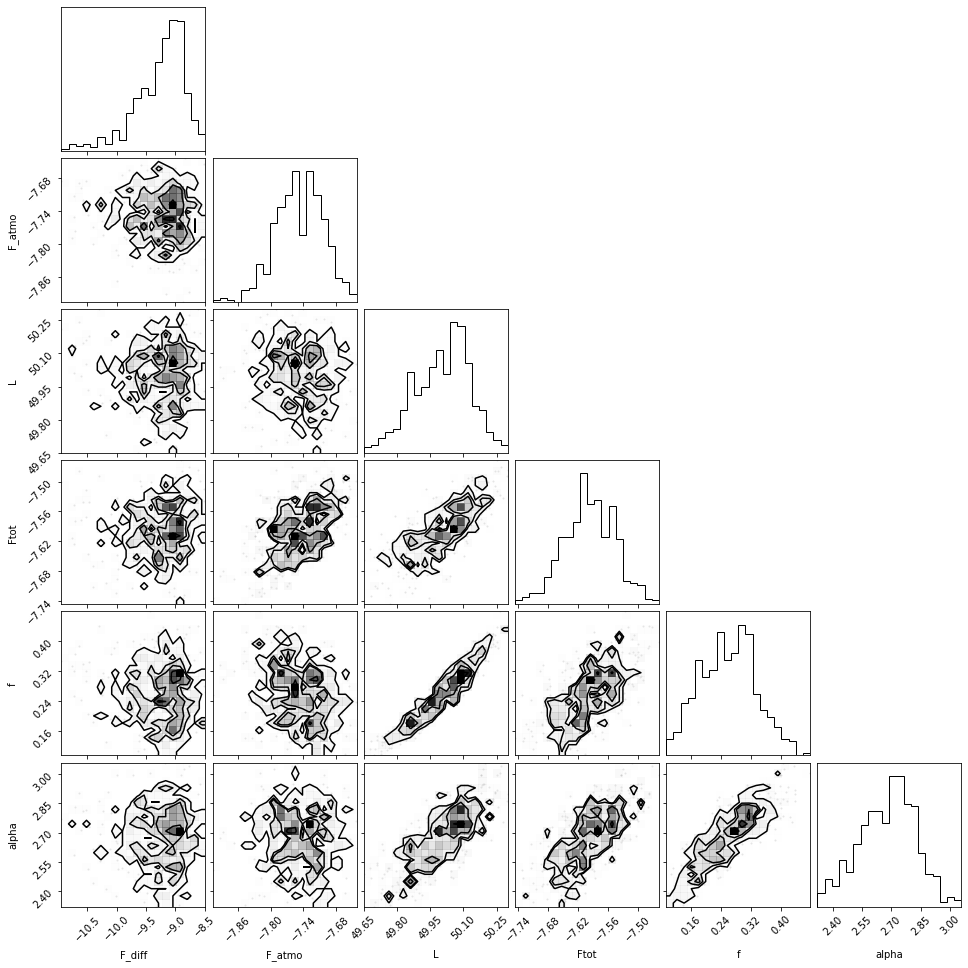

In [25]:
# View corner plot
chain = fit._fit_output.extract(permuted = True)
key_list = ['F_diff', 'F_atmo', 'L', 'Ftot', 'f', 'alpha']
labels = [r'F_diff', 'F_atmo', r'L', r'Ftot', r'f', 'alpha']
#truths = [np.log10(sim_inputs['F_diff']), np.log10(sim_inputs['F_atmo']), 
#          np.log10(sim_inputs['L']), np.log10((sum(source_ints)).value), 
#          (sum(source_ints[:-2]) / sum(source_ints)).value, 
#          sim_inputs['alpha']]

corner.corner(np.column_stack([np.log10(chain['F_diff']), np.log10(chain['F_atmo']), 
                               np.log10(chain['L']), np.log10(chain['Ftot']), 
                               chain['f'], chain['alpha']]),
              labels = labels);#, truths = truths);

In [26]:
#chain = fit.extract(permuted = True)
logprob = chain['lp'].transpose(1, 2, 0)
N = np.shape(logprob)[0]

# Account for background components
Ns = np.shape(logprob)[1] - 2
labels = ["src", "diff", "atmo"]

In [27]:
# Calculate association probabilities for each source-neutrino combo
nu_p = []
for lp in logprob:
    lps = []
    for src in range(Ns+2):
        lps.append(np.mean(np.exp(lp[src])))

    norm = sum(lps)
    ps = []
    for src in range(Ns+2):
        ps.append(lps[src] / norm)
    nu_p.append(ps)

# Normalise line weights
pmax = max(max(nu_p))

In [28]:
# Check individual event classifications
counter = 0
wrong = []
for i in range(len(nu_p)):
    classified = np.where(nu_p[i] == np.max(nu_p[i]))[0][0] == int(lam[i])
    if not classified:
        counter += 1
        wrong.append(i)
        print("P(src) =", nu_p[i][0])
        print("P(diff) =", nu_p[i][1])
        print("P(atmo) =", nu_p[i][2])
        print("Actual component is", labels[int(lam[i])])
print("")
print(counter, "events out of", len(nu_p), "misclassified")

NameError: name 'lam' is not defined